In [1]:
import networkx as nx
import numpy as np
import time
# Open adjencency list file and build the undirected graph
f=open("../lightningAdjList_26Out.txt", 'rb')
G_old=nx.read_multiline_adjlist(f)
f.close()
f=open("../lightningAdjList_26Nov.txt", 'rb')
G_new=nx.read_multiline_adjlist(f)
f.close()

# Clean graphs from smallest components
G_old = max(nx.connected_component_subgraphs(G_old), key=len)
G_new = max(nx.connected_component_subgraphs(G_new), key=len)

print("Number of nodes in old graph: " + str(G_old.number_of_nodes()))
print("Number of edges in old graph: " + str(G_old.number_of_edges()))
print("Number of nodes in new graph: " + str(G_new.number_of_nodes()))
print("Number of edges in new graph: " + str(G_new.number_of_edges()))

# Read alias file and create a pub_key -> alias dic

Number of nodes in old graph: 1642
Number of edges in old graph: 8506
Number of nodes in new graph: 1877
Number of edges in new graph: 12386


### Compute the average shortest path length

In [2]:
print("Old Average shortest path length: " + str(nx.average_shortest_path_length(G_old)))
print("New Average shortest path length: " + str(nx.average_shortest_path_length(G_new)))

Old Average shortest path length: 2.8951064418846832
New Average shortest path length: 2.8694566591655466


In [3]:
# Get the all pairs shortest paths for the two graphs
all_pairs_shortest_paths_list = []
all_pairs_shortest_paths_list.append(dict(nx.all_pairs_shortest_path(G_old)))
all_pairs_shortest_paths_list.append(dict(nx.all_pairs_shortest_path(G_new)))
graphs_list = []
graphs_list.append(G_old)
graphs_list.append(G_new)

In [4]:
# The bottleneck of a path
minCap = 10**10

# Capacity of the edge we are iteration in
edgeCap = 0

# List of lists of cumulative shortest path capacitties
pathsWithCapacityList = []

minCapacityList = []

for index, pair_shortest_path in enumerate(all_pairs_shortest_paths_list):
    
    pathsWithCapacity = [0] * 100
    minCapacity = []

    # Iterate through all the shortest paths
    for source, paths in pair_shortest_path.items():
    
        # Iterate through all the paths starting from one source
        for target, path in paths.items():
        
            # Make sure we only consider paths to to other nodes
            if len(path) > 1:
                
                # Reset threshold capacity
                minCap = 10**10
                # Iterate through edges of path and get threshold capacity
                for nodeNumber in range(0, len(path) - 1):
                    edgeCap = (graphs_list[index].get_edge_data(path[nodeNumber], path[nodeNumber + 1]))["capacity"]
                    if edgeCap < minCap:
                        minCap = edgeCap
    
                # Save the threshold capacity
                minCapacity.append(minCap)
                
                # Save threshold against predefined capacities
                for i in range(0,100):
                    if 10000*i < minCap:
                        pathsWithCapacity[i]+=1
                    
    pathsWithCapacityList.append(pathsWithCapacity)
    minCapacityList.append(minCapacity)

In [5]:
import random

flowsWithCapacityList = []

for G in graphs_list:
    
     # Get the flow value between some random pairs of nodes and store it
    nodes =  list(G.nodes())
    maxFlows = []
    numNodes = len(nodes)

    for i in range (0, 100):
    
        #Get a random source and sink
        randomResult = random.sample(range(0, numNodes - 1), 2)
        source = nodes[randomResult[0]]
        sink = nodes[randomResult[1]]
    
        # Make sure they are different
        if(source != sink):
            flow_value = nx.maximum_flow_value(G, source, sink)
            maxFlows.append(flow_value)
        
        if i % 100 == 0:
            print(i)
        
    # Sort flow values from smallest to largest
    maxFlows.sort(reverse=True)

    flowsWithCapacity = [0] * 100

    # Get a cumulative flowsWithCapacity list so we can plot the graph
    for i in range(0,100):
        for maxFlow in maxFlows:
            if 10000*i < maxFlow:
                flowsWithCapacity[i]+=1
            else:
                break
    
    flowsWithCapacityList.append(flowsWithCapacity)

0
0


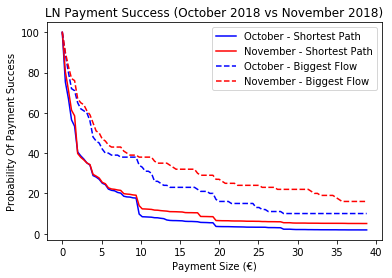

In [14]:
import matplotlib.pyplot as plt

for i, pathsWithCapacity in enumerate(pathsWithCapacityList):

    # Graph with Probability of payment success as a function of payments size (€)
    totalPaths = pathsWithCapacity[0]
    paymentProbPath = [(i/totalPaths)*100 for i in pathsWithCapacity]
    paymentSizePath = [(10000*i)*0.00003920 for i in range(0,100)]

    if i == 0:
        plt.plot(paymentSizePath, paymentProbPath, 'b', label="October - Shortest Path")
    elif i == 1:
        plt.plot(paymentSizePath, paymentProbPath, 'r', label="November - Shortest Path")
        
for i, flowsWithCapacity in enumerate(flowsWithCapacityList):
    
    # Graph with Probability of payment success as a function of payments size (satoshis)
    totalFlows = flowsWithCapacity[0]
    paymentProbFlow = [(i/totalFlows)*100 for i in flowsWithCapacity]
    paymentSizeFlow = [(10000*i)*0.00003920 for i in range(0,100)]

    if i == 0:
        plt.plot(paymentSizeFlow, paymentProbFlow, 'b', linestyle='--', label="October - Biggest Flow")
    if i == 1:
        plt.plot(paymentSizeFlow, paymentProbFlow, 'r', linestyle='--', label="November - Biggest Flow")

plt.title("LN Payment Success (October 2018 vs November 2018)")
plt.ylabel("Probability Of Payment Success")
plt.xlabel("Payment Size (€)")

plt.legend()
plt.show()

### Shortest paths average threshold capacity

In [15]:
import statistics

oldAverage = (statistics.mean(minCapacityList[0]))*0.00003920
oldMedian = (statistics.variance(minCapacityList[0]))*0.00003920
newAverage = (statistics.mean(minCapacityList[1]))*0.00003920
newMedian = (statistics.variance(minCapacityList[1]))*0.00003920

print("Old average/variance threshold capacity:" + str(oldAverage) + "/" + str(oldMedian))
print("New average/variance threshold capacity:" + str(newAverage) + "/" + str(newMedian))

Old average/variance threshold capacity:5.69637396707839/9664957.654728193
New average/variance threshold capacity:11.606476636573127/40233414.96982585
